In [1]:
import os
import time
import pickle
import numpy as np
from scipy.stats import skew
from scipy.stats import norm as sp_norm

import torch
from torch import nn
from accelerate import Accelerator

import util as U
from spender import SpectrumAutoencoder
from spender.data import desi_qso as desi 

/home/chhahn/projects/spender_qso/bin/london/util.py:24: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _trapz_rebin(x, y, edges, results):


In [2]:
from sklearn.mixture import GaussianMixture as GMix

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [4]:
print("torch.cuda.device_count():",torch.cuda.device_count())

torch.cuda.device_count(): 1


In [5]:
def load_model(filename, models, instruments):
    device = instruments[0].wave_obs.device
    model_struct = torch.load(filename, map_location=device)
    #wave_rest = model_struct['model'][0]['decoder.wave_rest']
    
    for i, model in enumerate(models):
        # backwards compat: encoder.mlp instead of encoder.mlp.mlp
        if 'encoder.mlp.mlp.0.weight' in model_struct['model'][i].keys():
            from collections import OrderedDict
            model_struct['model'][i] = OrderedDict([(k.replace('mlp.mlp', 'mlp'), v) for k, v in model_struct['model'][i].items()])
        # backwards compat: add instrument to encoder
        try:
            model.load_state_dict(model_struct['model'][i], strict=False)
        except RuntimeError:
            model_struct['model'][i]['encoder.instrument.wave_obs']= instruments[i].wave_obs
            #model_struct['model'][i]['encoder.instrument.skyline_mask']= instruments[i].skyline_mask
            model.load_state_dict(model_struct[i]['model'], strict=False)

    losses = model_struct['losses']
    return models, losses

In [6]:
# define instruments
instruments = [ desi.DESI() ]

In [7]:
latents = 10 
z_min, z_max = 2.1, 3.5

# restframe wavelength for reconstructed spectra
# Note: represents joint dataset wavelength range
lmbda_min = instruments[0].wave_obs[0]/(1.0+z_max) # 2000 A
lmbda_max = instruments[0].wave_obs[-1]/(1.0+z_min) # 9824 A
bins = 9780
wave_rest = torch.linspace(lmbda_min, lmbda_max, bins, dtype=torch.float32)

# define and train the model
n_hidden = (64, 256, 1024)
models = [ SpectrumAutoencoder(instrument,
                               wave_rest,
                               n_latent=latents,
                               n_hidden=n_hidden,
                               act=[nn.LeakyReLU()]*(len(n_hidden)+1)
                               )
          for instrument in instruments ]

In [8]:
models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.pt', models, instruments)

In [9]:
ibatch = 0 
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.pkl' % (ibatch), "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)

In [10]:
true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))

In [11]:
with torch.no_grad():
    models[0].eval()
    instruments[0].eval()

    s = models[0].encode(spec)
    spec_rest = models[0].decode(s)

/home/chhahn/projects/spender_qso/bin/london/util.py:23: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_trapz_rebin" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/chhahn/projects/spender_qso/bin/london/util.py (23)

File "util.py", line 23:
def centers2edges(centers):
    <source elided>

@numba.jit
^

  @numba.jit
/home/chhahn/projects/spender_qso/bin/london/util.py:23: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_trapz_rebin" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "util.py", line 69:
def _trapz_rebin(x, y, edges, results):
    <source elided>

    for i in range(nbin):
    ^

  @numba.jit
/home/chhahn/.conda/envs/gqp/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "_trapz_rebin" was compiled in object mode without f

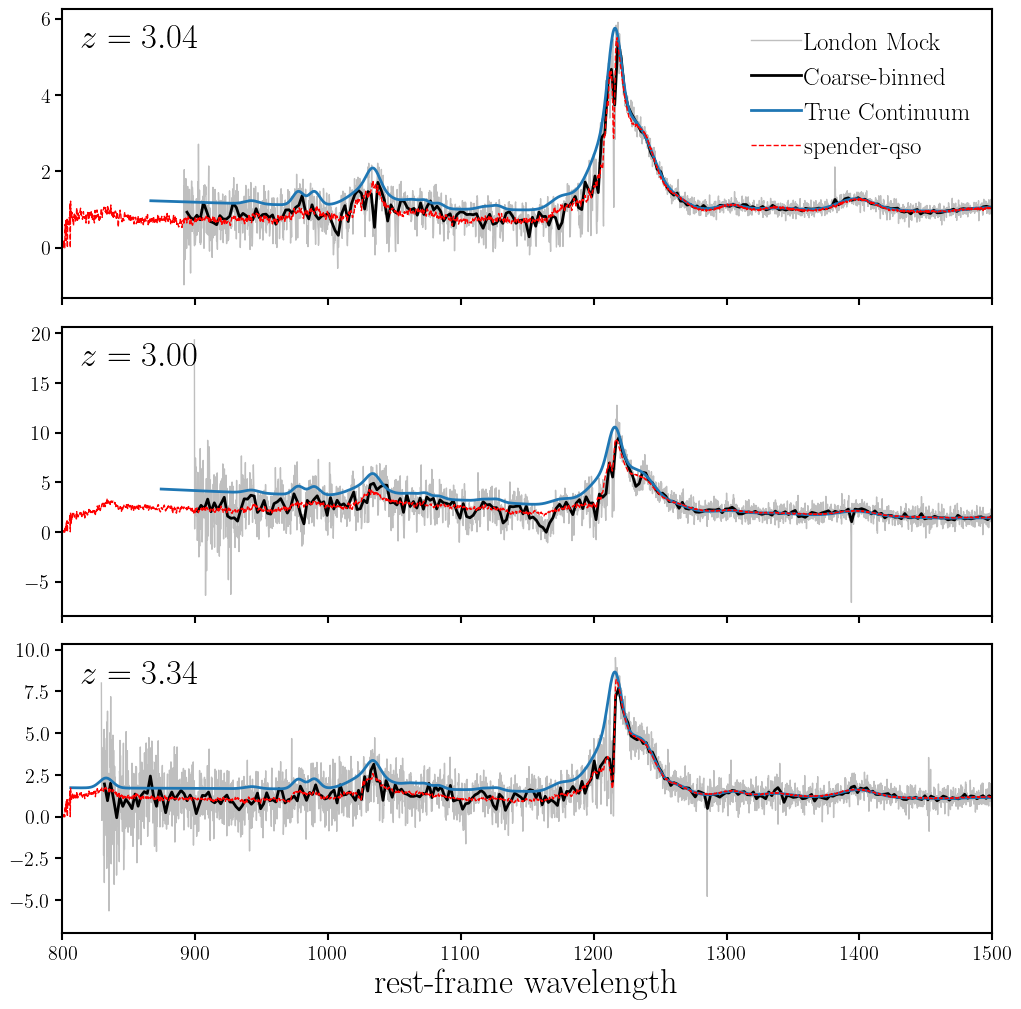

In [12]:
highzs = np.arange(len(z))[z > 3.0][22:25]

fig = plt.figure(figsize=(12,4*len(highzs)))

wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate(highzs):
    sub = fig.add_subplot(len(highzs), 1, ii+1)
    sub.plot(models[0].wave_obs/(1 + z[igal]), spec[igal], c='gray', alpha=0.5, lw=1, label='London Mock')

    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), spec[igal], xnew=wave_rebin)
    sub.plot(wave_rebin/(1+z[igal]), spec_rebin, c='k', lw=2, label='Coarse-binned')

    sub.plot(np.linspace(3.50e3, 1e4, 3251)/(1 + z[igal]), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Continuum')
    sub.plot(models[0].wave_rest, spec_rest[igal], color='r', lw=1, ls='--', label='spender-qso')
    
    
    #sub.axvline(1215.*(1+z[igal]), linestyle='--', color='k')

    sub.text(0.02, 0.95, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=25, transform=sub.transAxes)

    sub.set_xlim(models[0].wave_rest[0], 1500.)#models[0].wave_rest[-1])
    if ii < len(highzs)-1: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', fontsize=18, handletextpad=0.1)
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

95
525
393


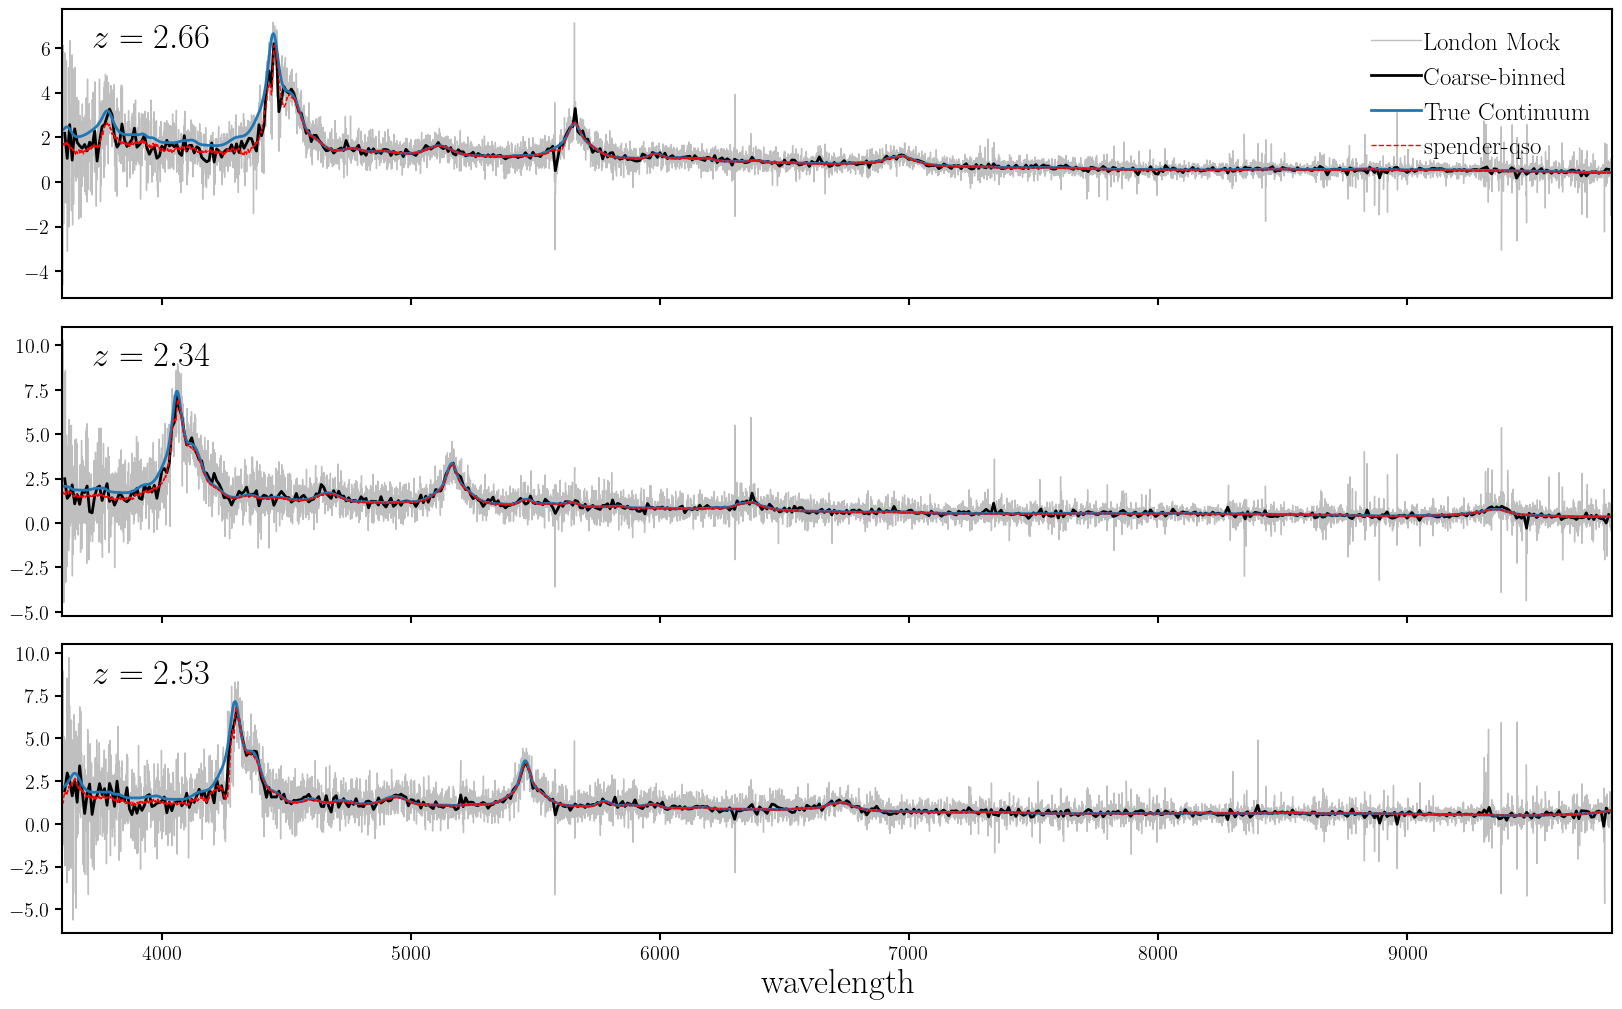

In [13]:
fig = plt.figure(figsize=(20,12))

wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate([95, 525, 393]): #np.random.choice(np.arange(len(z)), size=3, replace=False)):
    print(igal)
    sub = fig.add_subplot(len(highzs), 1, ii+1)
    sub.plot(models[0].wave_obs, spec[igal], c='gray', alpha=0.5, lw=1, label='London Mock')

    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), spec[igal], xnew=wave_rebin)
    sub.plot(wave_rebin, spec_rebin, c='k', lw=2, label='Coarse-binned')

    sub.plot(np.linspace(3.50e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Continuum')
    sub.plot(models[0].wave_rest * (1+z[igal]), spec_rest[igal], color='r', lw=1, ls='--', label='spender-qso')
    
    
    #sub.axvline(1215.*(1+z[igal]), linestyle='--', color='k')

    sub.text(0.02, 0.95, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=25, transform=sub.transAxes)

    sub.set_xlim(models[0].wave_obs[0], models[0].wave_obs[-1])#models[0].wave_rest[-1])
    if ii < len(highzs)-1: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', fontsize=18, handletextpad=0.1)
sub.set_xlabel("wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

## quantitative assessment of performance

In [13]:
def LyA_continuum_amplitude(w, f): 
    '''estimate the amplitude of the continuum in the LyA forest wavelength range'''
    wlim = (w > 1040.) & (w < 1200.)
    return np.median(f[wlim])

first lets calculate a number of properties of the reconstructions

In [16]:
recon_rebin, noise_forest, skewy = [], [], []
A_lya_true, A_lya_spender = [], []

for igal in range(len(z)):
    # spender reconstruction rebinned 
    recon_rebin.append(U.trapz_rebin(models[0].wave_rest * (1+z[igal]), spec_rest[igal], xnew=models[0].wave_obs))
    
    # noise level in the forest
    in_forest = (models[0].wave_obs/(1+z[igal]) > 1040) & (models[0].wave_obs/(1+z[igal]) < 1200)
    noise_forest.append(np.median(np.array(w[igal])[in_forest]**-0.5))
    
    # skewness of p(Spender - spec) in the forest 
    skewy.append(skew((recon_rebin[-1] - np.array(spec[igal]))[in_forest]))
    
    # amplitude of the forest region
    A_lya_true.append(LyA_continuum_amplitude(np.linspace(3.50e3, 1e4, 3251)/(1 + z[igal]), true_cont[igal]/norm[igal]))
    A_lya_spender.append(LyA_continuum_amplitude(models[0].wave_rest, spec_rest[igal]))
    
recon_rebin = np.array(recon_rebin)
noise_forest = np.array(noise_forest)
skewy = np.array(skewy)

A_lya_true = np.array(A_lya_true)
A_lya_spender = np.array(A_lya_spender)

np.save('recon_rebin.npy', recon_rebin)
np.save('noise_forst.npy', noise_forest)
np.save('skewy.npy', skewy)
np.save('A_lya_true.npy', A_lya_true)
np.save('A_lya_spender.npy', A_lya_spender)

NameError: name 'skwey' is not defined

In [14]:
recon_rebin = np.load('recon_rebin.npy')
noise_forest = np.load('noise_forst.npy')
skewy = np.load('skewy.npy')
A_lya_true = np.load('A_lya_true.npy')
A_lya_spender = np.load('A_lya_spender.npy')

In [15]:
dAlya = (A_lya_true-A_lya_spender)/noise_forest

lets check the properties of the bad continuum reconstructions

In [16]:
bad_recon = np.abs(A_lya_true - A_lya_spender) > noise_forest

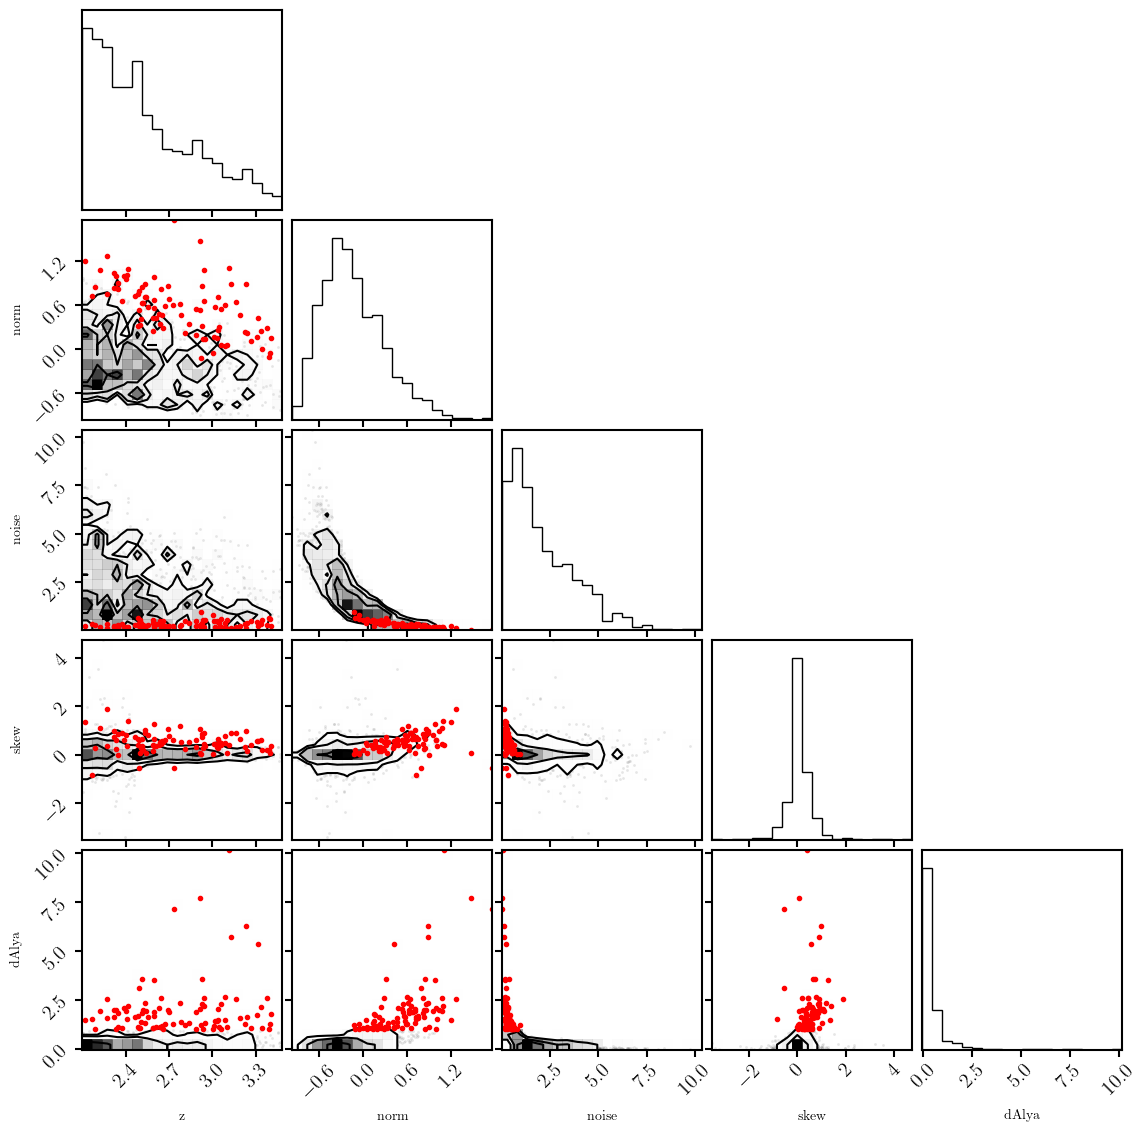

In [16]:
_data = np.array([np.array(z), np.log10(np.array(norm)), noise_forest, skewy, dAlya]).T
fig = DFM.corner(_data, labels=['z', 'norm', 'noise', 'skew', 'dAlya'])
DFM.overplot_points(fig, _data[bad_recon], color='r')
plt.show()

lets look at the $p({\rm spender} - {\rm flux})$ distribution in the forest region

gal 0, z=3.10 norm=2.26
skew 0.313, sigma=0.29, dAlya=0.88
[918.5710563117102, 925.0622852769596, 948.3640905685809, 969.5519580065007]
[909.1500100928054, 901.5096697296975, 910.6799056929615, 917.7362038025241]
[ 0.32374915 -0.21829279]
[0.35961105 0.29935942]
[0.4033049 0.5966951]


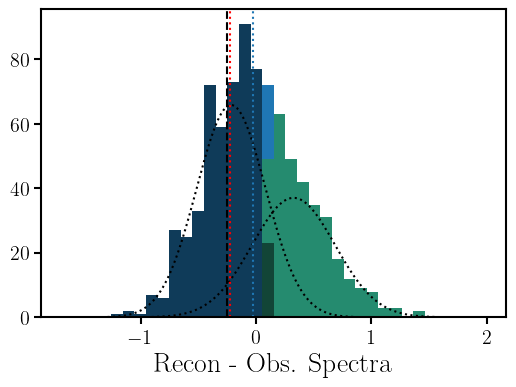

gal 1, z=2.86 norm=0.34
skew -0.092, sigma=2.08, dAlya=0.20
[3407.143256382791, 3432.3136661316266, 3449.8327420831165, 3465.120486109653]
[3397.8426982856163, 3409.0622708886895, 3412.630509694417, 3413.9674165751912]
[-0.08817332]
[2.17342148]
[1.]


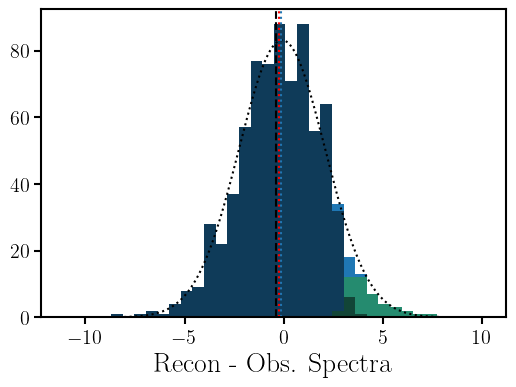

gal 2, z=2.66 norm=0.43
skew 0.070, sigma=1.97, dAlya=0.27
[3170.420439548165, 3194.646238980552, 3213.018360157978, 3223.1160118233365]
[3161.226148144392, 3171.660510471119, 3176.241194542885, 3172.5474091025835]
[0.01203087]
[2.08484539]
[1.]


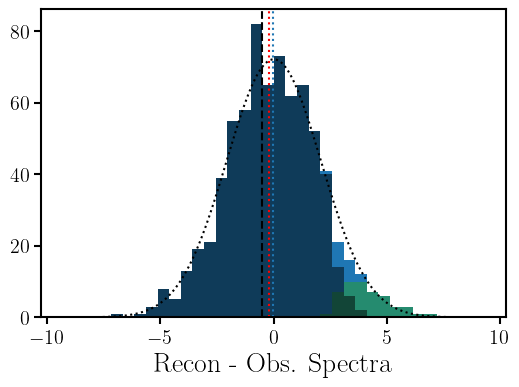

gal 3, z=2.94 norm=0.14
skew 0.048, sigma=4.66, dAlya=0.16
[4773.871645406588, 4792.115641583528, 4817.807525306534, 4841.167630406754]
[4764.535188909753, 4768.77450034144, 4780.461699319195, 4789.817119674162]
[0.03932578]
[4.98056739]
[1.]


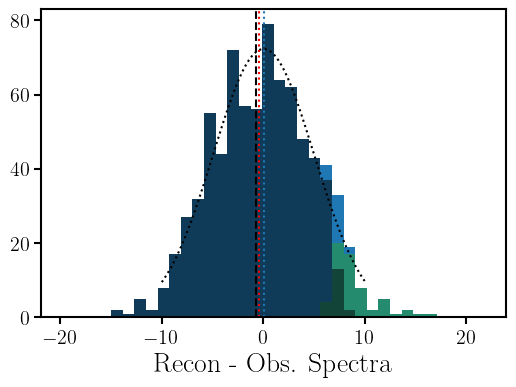

gal 4, z=2.85 norm=0.55
skew 0.181, sigma=1.30, dAlya=0.37
[2742.874321500534, 2765.045882186505, 2788.992826644326, 2808.901540720879]
[2733.5815404708383, 2741.8139296122663, 2751.8217025255444, 2757.791245057554]
[-0.16794198]
[1.42406756]
[1.]


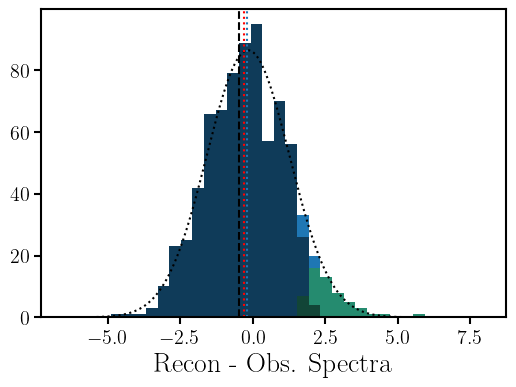

gal 5, z=2.95 norm=0.63
skew 0.006, sigma=1.09, dAlya=0.46
[2496.8829315980674, 2516.979305352168, 2530.5906949721566, 2552.3435425587286]
[2487.5388657071453, 2493.6191406248627, 2493.214431408468, 2500.951180158657]
[-0.10502158]
[1.16523394]
[1.]


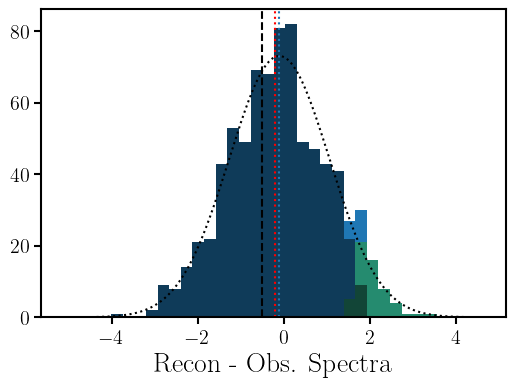

gal 6, z=3.48 norm=0.39
skew 0.039, sigma=1.24, dAlya=0.73
[3202.1487105612696, 3227.114149581305, 3254.7793151975934, 3279.4128358690136]
[3192.55282973532, 3203.1244475164303, 3216.395791893794, 3226.6354913262894]
[-0.14360312]
[1.43388575]
[1.]


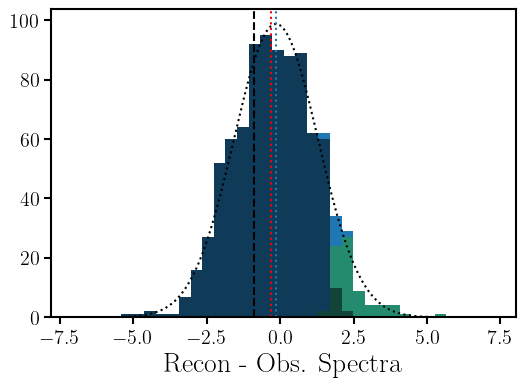

gal 7, z=2.93 norm=0.29
skew -0.077, sigma=2.36, dAlya=0.21
[3602.092155687029, 3626.7941124895788, 3650.734450800472, 3670.9530099295444]
[3592.760788251464, 3603.465693900667, 3613.4089810582127, 3619.630489033938]
[-0.11527539]
[2.37951444]
[1.]


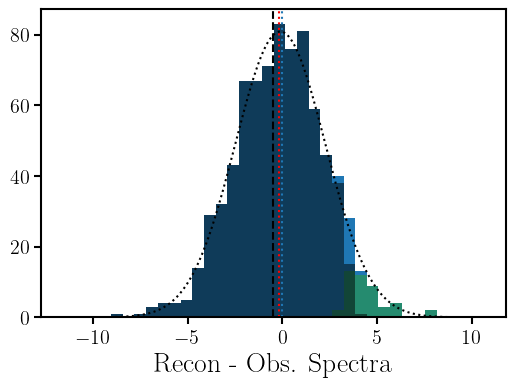

gal 8, z=3.34 norm=0.17
skew 0.034, sigma=3.07, dAlya=0.10
[4417.813861942351, 4441.333832592042, 4463.866249236458, 4478.863679918524]
[4408.28147851303, 4417.502874018741, 4425.736715519176, 4426.43557105726]
[0.03530158]
[3.05900598]
[1.]


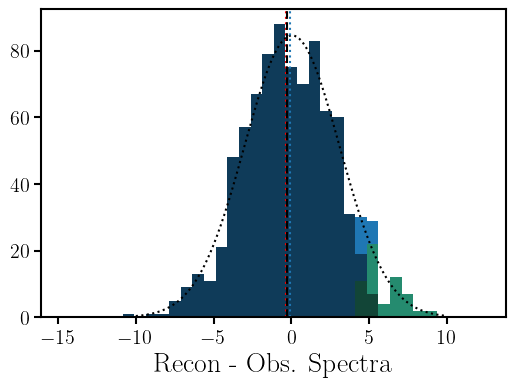

gal 9, z=3.15 norm=0.15
skew -0.015, sigma=3.76, dAlya=0.12
[4591.770907742889, 4617.565471131332, 4639.093693636902, 4656.340507893289]
[4582.328056341307, 4593.958342627378, 4601.322288030577, 4604.4048251845925]
[-0.11856589]
[3.81557148]
[1.]


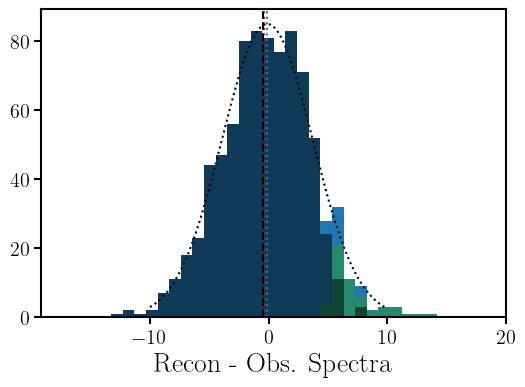

gal 10, z=3.10 norm=1.14
skew 0.081, sigma=0.56, dAlya=1.11
[2001.993828376188, 2020.8936006798485, 2041.2902055829077, 2063.9238771331134]
[1992.5752196956714, 1997.347078978557, 2003.6157708608414, 2012.1215293902721]
[-0.02829047]
[0.81351419]
[1.]


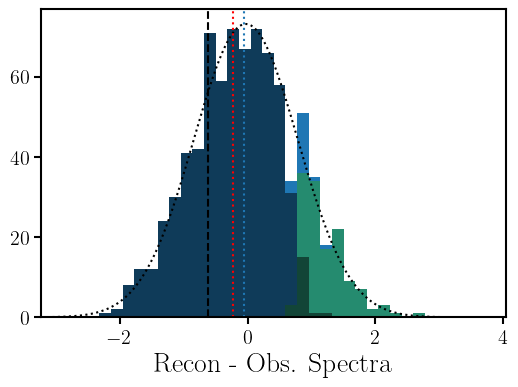

gal 11, z=3.09 norm=1.09
skew 0.482, sigma=0.40, dAlya=1.51
[1721.133960785546, 1696.5623431509512, 1717.134042288885, 1737.64259946022]
[1711.7202361123404, 1673.0280314679374, 1679.479143596063, 1685.8671137575898]
[-0.33325204  0.64358953]
[0.47593648 0.6130835 ]
[0.69893411 0.30106589]


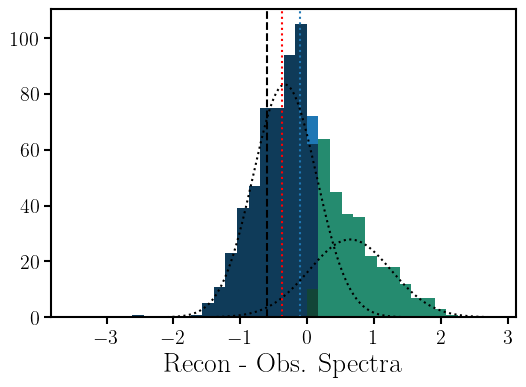

gal 12, z=3.26 norm=0.29
skew -0.125, sigma=1.95, dAlya=0.22
[3546.239273497732, 3570.3865440143286, 3587.1063687735755, 3606.1761266900576]
[3536.7441004440734, 3546.648611380182, 3549.125676558941, 3553.952674894935]
[0.02316486]
[1.92373428]
[1.]


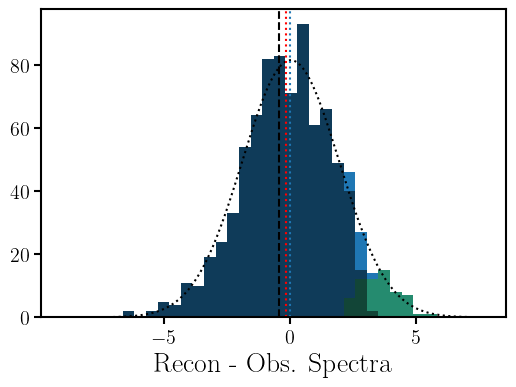

gal 13, z=2.99 norm=0.73
skew 0.039, sigma=0.91, dAlya=0.37
[2268.947542392333, 2294.517533781627, 2313.376450204454, 2331.5854101024997]
[2259.5808205008007, 2271.100729052796, 2275.909562638324, 2280.068439699071]
[-0.12356874]
[0.99259194]
[1.]


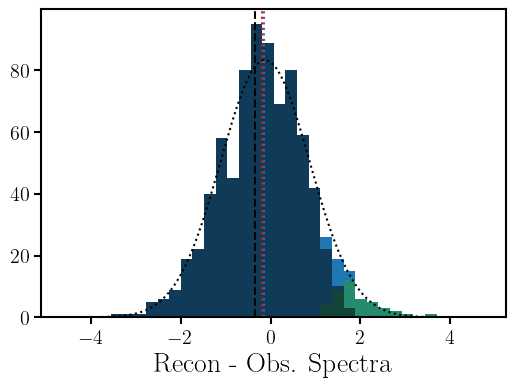

gal 14, z=3.45 norm=1.07
skew 0.337, sigma=0.46, dAlya=0.81
[1707.252995977579, 1716.0750109296546, 1733.1007252166085, 1753.3576913721568]
[1697.6705530521267, 1692.1189036160235, 1694.770953514799, 1700.6542552821686]
[ 0.44284891 -0.31703794]
[0.55272176 0.45247178]
[0.44777494 0.55222506]


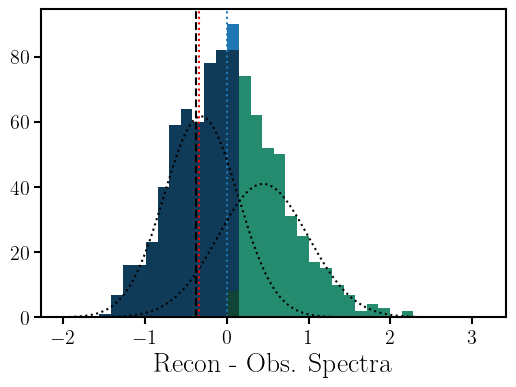

gal 15, z=3.41 norm=1.41
skew 0.353, sigma=0.24, dAlya=1.81
[958.6069634059922, 964.8625051256292, 980.5598151015597, 999.431355573535]
[949.0425792939786, 940.9515448455953, 942.3022786535054, 946.8272429574604]
[ 0.21176821 -0.27333805]
[0.37803918 0.3056889 ]
[0.41323771 0.58676229]


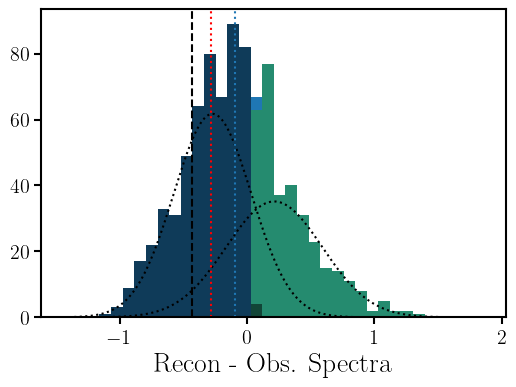

gal 16, z=3.39 norm=0.77
skew 0.198, sigma=0.66, dAlya=1.02
[2158.943825305585, 2182.8658390503588, 2194.002238947283, 2210.4780975017215]
[2149.3885321183147, 2158.9776060821832, 2155.781066198202, 2157.923984971735]
[-0.08498299]
[0.82103435]
[1.]


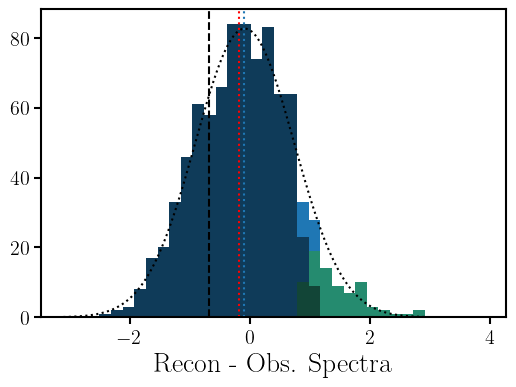

gal 17, z=3.31 norm=0.40
skew -0.140, sigma=1.36, dAlya=0.19
[3071.722870104447, 3094.363847365614, 3116.196388146593, 3136.1011988851274]
[3062.2043595631194, 3070.567571012296, 3078.1223459812836, 3083.7493909078266]
[0.12016073]
[1.42612668]
[1.]


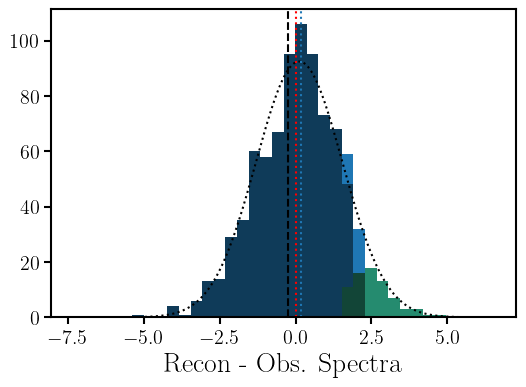

gal 18, z=3.26 norm=0.38
skew 0.013, sigma=1.46, dAlya=0.27
[3095.91601963298, 3121.3282747127746, 3140.4338989500748, 3155.5350749900786]
[3086.4208465793213, 3097.590342078628, 3102.4532067354403, 3103.311623194956]
[-0.02257103]
[1.47697211]
[1.]


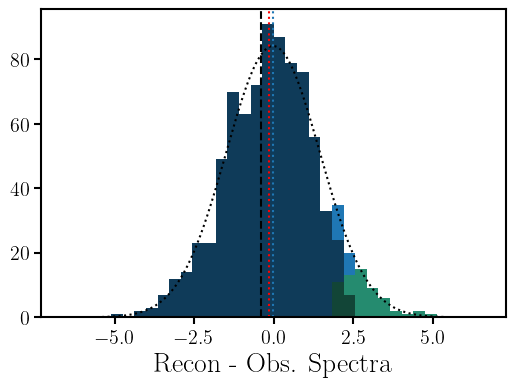

gal 19, z=3.42 norm=0.24
skew 0.053, sigma=1.97, dAlya=0.20
[3897.0341847849872, 3924.1451509723884, 3946.7680232700136, 3961.73897522271]
[3887.465270659712, 3900.2228656592, 3908.4923667689122, 3909.109947533696]
[0.06134847]
[2.17622495]
[1.]


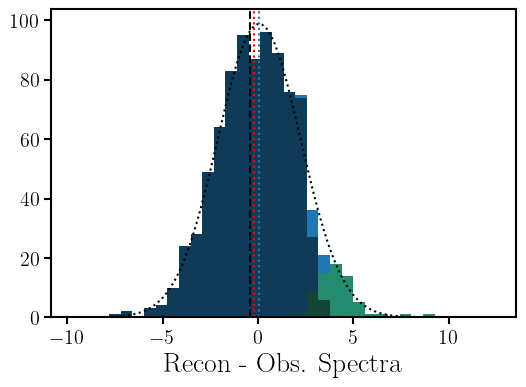

gal 20, z=3.48 norm=0.19
skew -0.201, sigma=2.44, dAlya=0.21
[4272.471314316047, 4293.354451240632, 4311.002744061422, 4331.0881898208045]
[4262.877666879497, 4269.370332649258, 4272.628154315224, 4278.323128919781]
[-0.12275259]
[2.61253968]
[1.]


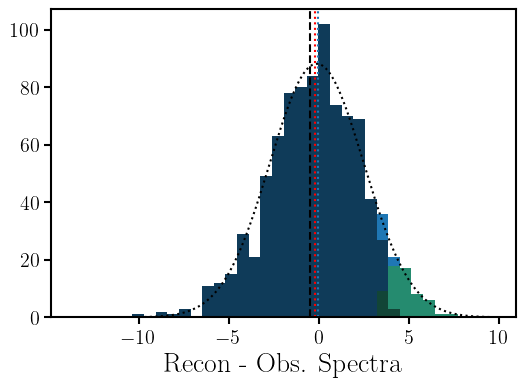

gal 21, z=2.13 norm=0.27
skew -0.030, sigma=6.93, dAlya=0.04
[1294.982147931973, 1311.645630548152, 1323.238045844015, 1334.417320845053]
[1288.4986539018537, 1295.4368954728538, 1297.3040697235379, 1298.7581036793968]
[0.26478894]
[7.23699499]
[1.]


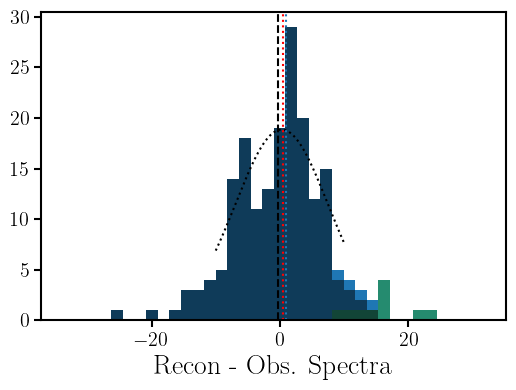

gal 22, z=2.26 norm=0.30
skew -0.043, sigma=4.75, dAlya=0.10
[2533.6143639940115, 2495.5890284663756, 2505.1834365837262, 2525.874054452088]
[2525.666744770273, 2475.719980407029, 2473.392959688772, 2482.162148721526]
[ 1.58063599 -0.58029882 -0.9953866 ]
[ 5.68361809  3.89372904 13.1839535 ]
[0.27883852 0.62736767 0.09379381]


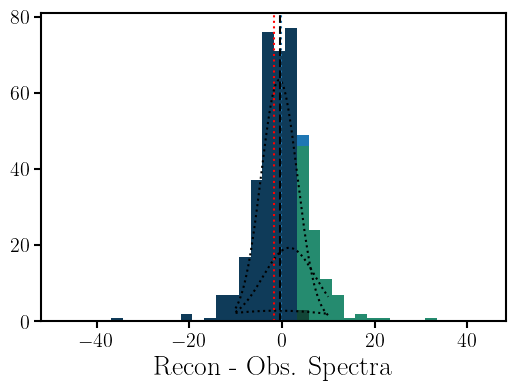

gal 23, z=2.35 norm=0.42
skew 0.498, sigma=2.99, dAlya=0.14
[2850.0215716337916, 2828.5871781781625, 2846.5603764548882, 2864.4815112084116]
[2841.51776386746, 2807.327658762333, 2812.545145389561, 2817.710568493587]
[-0.27758317  0.27825929]
[2.25313831 4.85262737]
[0.52835899 0.47164101]


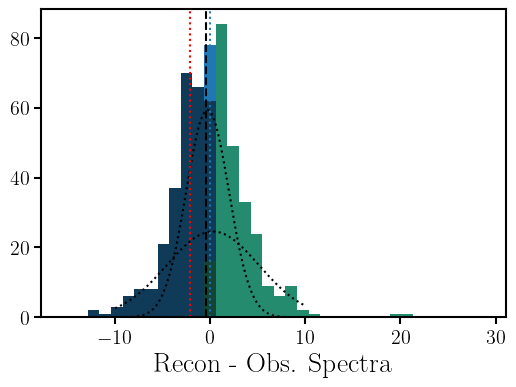

gal 24, z=2.24 norm=0.23
skew -0.470, sigma=6.49, dAlya=0.06
[2541.132275295293, 2559.7600631454156, 2534.3446157273556, 2529.670577994539]
[2533.388039716342, 2540.3994741980387, 2503.3676734115525, 2487.07728231031]
[ -5.56950428   1.29348234 -57.54448067   8.18025841]
[6.58212079e+00 5.30536262e+00 1.00000000e-03 9.60098320e+00]
[0.34321686 0.51106368 0.0028169  0.14290256]


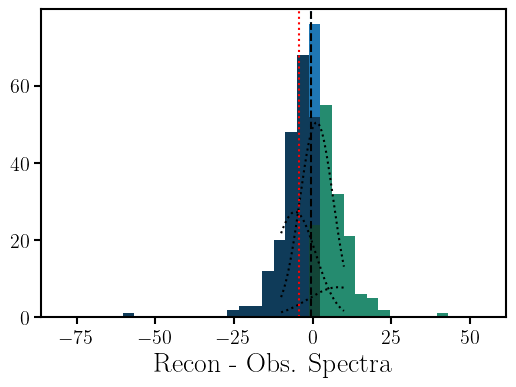

gal 25, z=2.28 norm=1.35
skew -0.015, sigma=1.07, dAlya=0.21
[1424.9782842831835, 1445.6458935490186, 1456.785033151915, 1469.2987683482702]
[1416.926552335533, 1425.516563679892, 1424.5781053613125, 1425.0142426361917]
[-0.12907678]
[1.33308364]
[1.]


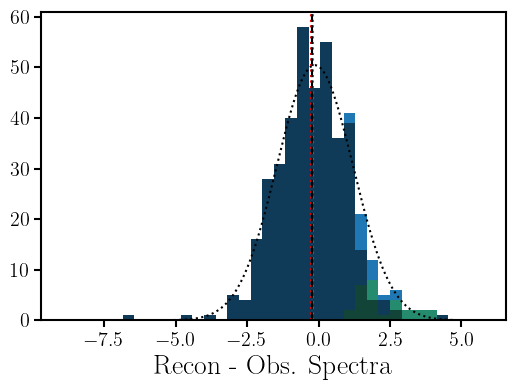

gal 26, z=2.30 norm=1.13
skew 1.195, sigma=1.21, dAlya=0.13
[1720.4532741873654, 1659.0261536794126, 1670.9534066164515, 1685.5949914779349]
[1712.23033950836, 1638.4688169818992, 1638.0616679004302, 1640.3688507434053]
[-1.10787211  0.84361506  0.35983094]
[0.92001848 3.27266802 0.86838437]
[0.35184391 0.12262043 0.52553566]


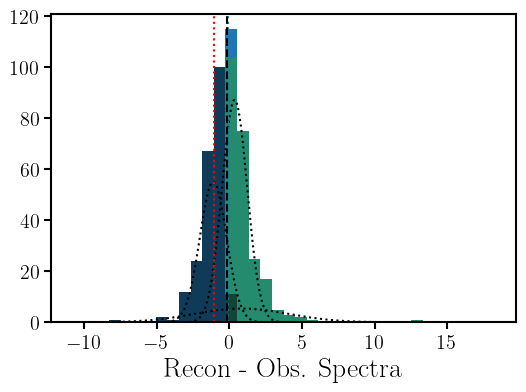

gal 27, z=2.33 norm=0.39
skew 0.120, sigma=3.25, dAlya=0.00
[2847.2752840114513, 2834.820059324185, 2855.582816065996, 2872.8114835020388]
[2838.8621321580013, 2813.78717969056, 2821.9302086521966, 2826.5391483080643]
[ 0.15375684 -0.20002291]
[5.81439276 2.81063704]
[0.37988589 0.62011411]


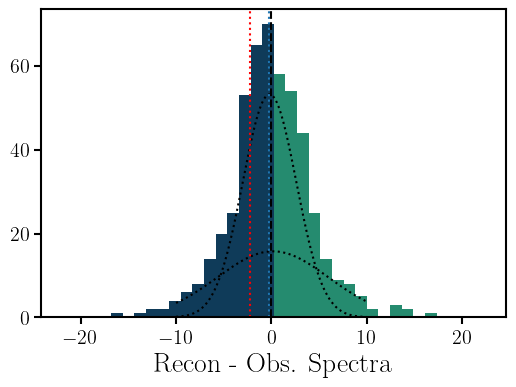

gal 28, z=2.31 norm=0.91
skew 0.238, sigma=1.46, dAlya=0.26
[1847.8550421426928, 1827.88827935368, 1846.0663768162706, 1865.1494873269526]
[1839.5666708744416, 1807.1673511830518, 1812.9128917432654, 1819.5634453515704]
[0.2090822  0.03180155]
[2.3657284  1.08543854]
[0.41229046 0.58770954]


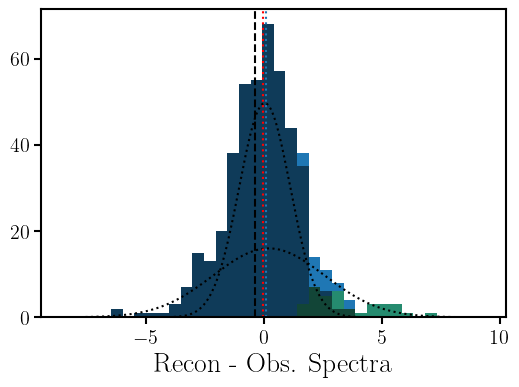

gal 29, z=2.25 norm=0.23
skew 0.093, sigma=6.18, dAlya=0.05
[2507.5752779007, 2527.4327777598305, 2526.407811687921, 2542.4743933143177]
[2499.7482718894234, 2507.865262731639, 2495.0997876428146, 2499.425860252297]
[ 0.35031701  7.67010246 -8.22714967]
[3.47847007 6.48047062 5.24226784]
[0.55779714 0.18849892 0.25370395]


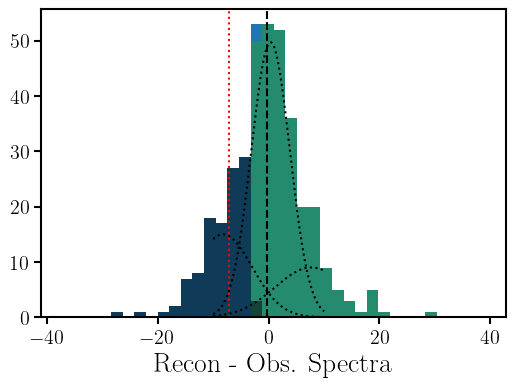

In [37]:
for ii, igal in enumerate(np.arange(len(z))[:30]):
    inforest = (models[0].wave_obs/(1+z[igal]) > 1040) & (models[0].wave_obs/(1+z[igal]) < 1200) & (w[igal] > 0.)
    drecon = np.array(recon_rebin[igal] - np.array(spec[igal]))[inforest]
    
    print('gal %i, z=%.2f norm=%.2f' % (igal, float(z[igal]), float(norm[igal])))
    print('skew %.3f, sigma=%.2f, dAlya=%.2f' % (skewy[igal], noise_forest[igal], dAlya[igal]))
    
    # fit a Gaussian mixture model 
    gmms, bics, aics = [], [], []
    for i_n, n in enumerate(np.arange(1,5)): 
        gmm = GMix(n_components=n)
        gmm.fit(drecon.reshape(-1, 1))
        bics.append(gmm.bic(drecon.reshape(-1, 1))) # bayesian information criteria
        aics.append(gmm.aic(drecon.reshape(-1, 1))) # bayesian information criteria
        gmms.append(gmm)    
    print(bics)        
    #bics = np.array(bics)
    #bics[1:] -= bics[0]*0.01
    print(aics)
    i_best = np.array(aics).argmin()
    ncomp = np.arange(1,5)[i_best]
    
    gmm_means = gmms[i_best].means_.flatten()
    gmm_sigmas = gmms[i_best].covariances_.flatten()**0.5
    gmm_weights = gmms[i_best].weights_
    print(gmm_means)
    print(gmm_sigmas)
    print(gmm_weights)
    
    fig = plt.figure(figsize=(6,4))
    sub = fig.add_subplot(111)
    h = sub.hist(drecon, range=(drecon.min()*1.5, drecon.max()*1.5), bins=40)
    
    # plot best-fit GMM
    _x = np.linspace(-10, 10, 10000)
    for _i in range(ncomp):
        _gauss = sp_norm.pdf(_x, gmm_means[_i], gmm_sigmas[_i])
        sub.plot(_x, np.sum(h[0] * np.diff(h[1])) * gmm_weights[_i] * _gauss, c='k', ls=':')
        
        
    #sig1 = drecon > np.array(w[igal])[inforest]**-0.5
    #_ = sub.hist(drecon[sig1], range=(drecon.min()*1.5, drecon.max()*1.5), bins=40, color='C1')
    #sig3 = drecon > 3. * np.array(w[igal])[inforest]**-0.5
    #_ = sub.hist(drecon[sig3], range=(drecon.min()*1.5, drecon.max()*1.5), bins=40, color='r')
    
    # select continuum Gaussian
    if ncomp > 1: 
        couldbe_cont = (gmm_means < 0.) & (gmm_weights > 0.1)
        if np.sum(couldbe_cont) > 0: 
            g_cont = np.arange(ncomp)[couldbe_cont][np.argmin(gmm_means[np.arange(ncomp)[couldbe_cont]])]
            g_next = np.arange(ncomp)[gmm_means > gmm_means[g_cont]][np.argmin(gmm_means[gmm_means > gmm_means[g_cont]] - gmm_means[g_cont])]
            
            if (gmm_means[g_next] - gmm_means[g_cont])/gmm_sigmas[g_cont] < 0.5: 
                gmm_sig = drecon > gmm_means[g_next]
            else: 
                gmm_sig = drecon > gmm_means[g_cont] + gmm_sigmas[g_cont]
        else: 
            gmm_sig = drecon > 1.5 * np.array(w[igal])[inforest]**-0.5
    else: 
        gmm_sig = drecon > 1.5 * np.array(w[igal])[inforest]**-0.5
    _ = sub.hist(drecon[gmm_sig], range=(drecon.min()*1.5, drecon.max()*1.5), bins=40, color='C2', alpha=0.5)
    
    _ = sub.hist(drecon[~gmm_sig], range=(drecon.min()*1.5, drecon.max()*1.5), bins=40, color='k', alpha=0.5)
    sub.axvline(np.median(drecon), color='C0', linestyle=':')
    sub.axvline(np.median(drecon[~gmm_sig]), color='r', linestyle=':')
    #_ = sub.hist((true_rebin[igal] - spec[igal])[inforest], alpha=0.5, range=(-5., 5), bins=40)
    sub.axvline((np.array(A_lya_spender) - np.array(A_lya_true))[igal], color='k', linestyle='--')    
    sub.set_xlabel('Recon - Obs. Spectra', fontsize=20)
    sub.set_xlim(drecon.min()*1.5, drecon.max()*1.5)
    plt.show()

gal 0, z=3.10 norm=2.26
skew 0.313, sigma=0.29, dAlya=0.88
[-0.21829279  0.32374915]
[0.29935942 0.35961105]
[0.5966951 0.4033049]


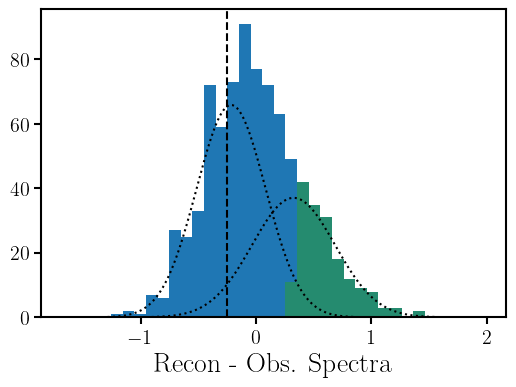

gal 1, z=2.86 norm=0.34
skew -0.092, sigma=2.08, dAlya=0.20
[-1.22170349  1.10276618]
[1.90068435 1.76717132]
[0.51234891 0.48765109]


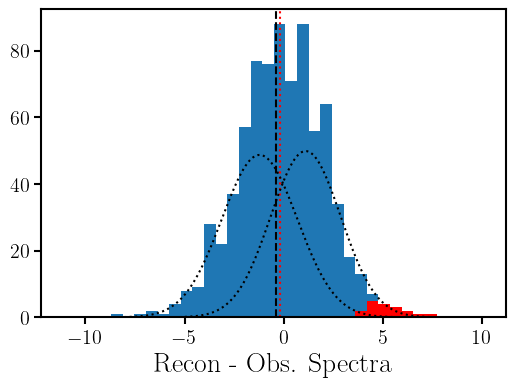

gal 2, z=2.66 norm=0.43
skew 0.070, sigma=1.97, dAlya=0.27
[-1.13541069  1.17710524]
[1.69086854 1.77840668]
[0.50381247 0.49618753]


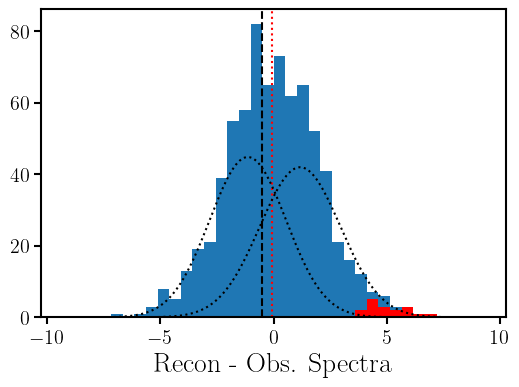

gal 3, z=2.94 norm=0.14
skew 0.048, sigma=4.66, dAlya=0.16
[ 3.16976115 -3.56764838]
[3.78326601 3.54889508]
[0.53536513 0.46463487]


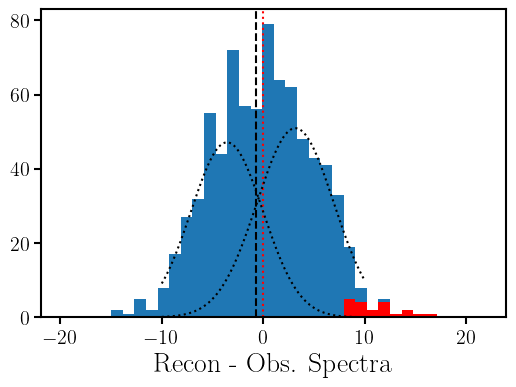

gal 4, z=2.85 norm=0.55
skew 0.181, sigma=1.30, dAlya=0.37
[-0.99476305  0.71161743]
[1.08280014 1.19882697]
[0.51545327 0.48454673]


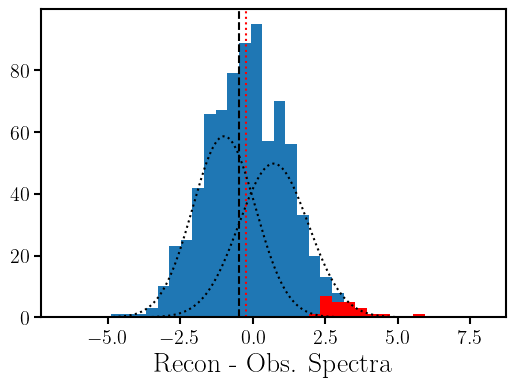

gal 5, z=2.95 norm=0.63
skew 0.006, sigma=1.09, dAlya=0.46
[ 0.67966545 -0.82141064]
[0.89569683 0.88857376]
[0.47725033 0.52274967]


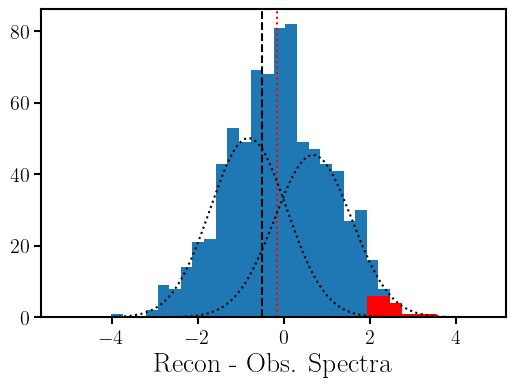

gal 6, z=3.48 norm=0.39
skew 0.039, sigma=1.24, dAlya=0.73
[ 0.75046786 -1.0461164 ]
[1.13231494 1.10262682]
[0.50234954 0.49765046]


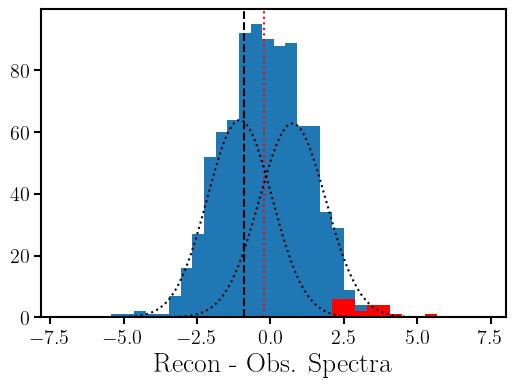

gal 7, z=2.93 norm=0.29
skew -0.077, sigma=2.36, dAlya=0.21
[ 1.19166351 -1.67250466]
[1.87514804 1.93876039]
[0.54369338 0.45630662]


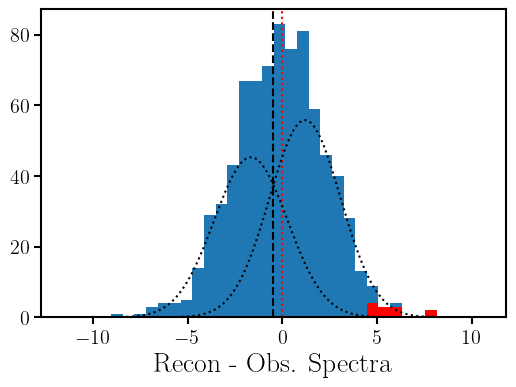

gal 8, z=3.34 norm=0.17
skew 0.034, sigma=3.07, dAlya=0.10
[ 2.12039154 -1.727172  ]
[2.40425771 2.36640837]
[0.45807524 0.54192476]


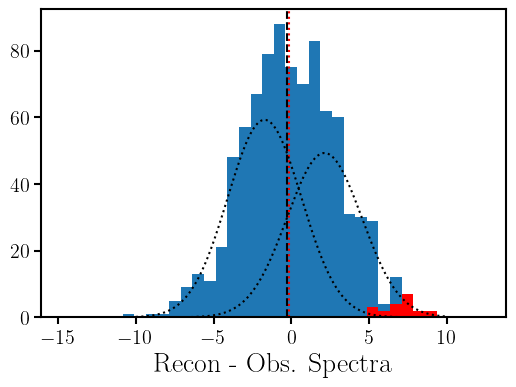

gal 9, z=3.15 norm=0.15
skew -0.015, sigma=3.76, dAlya=0.12
[-2.19901577  2.12249096]
[3.20663883 3.07896088]
[0.51858229 0.48141771]


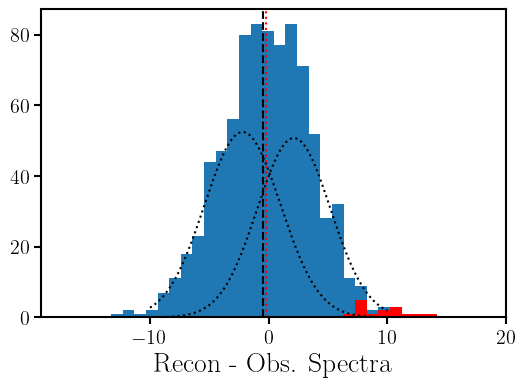

gal 10, z=3.10 norm=1.14
skew 0.081, sigma=0.56, dAlya=1.11
[ 0.54085677 -0.53375603]
[0.62274225 0.60163571]
[0.47036994 0.52963006]


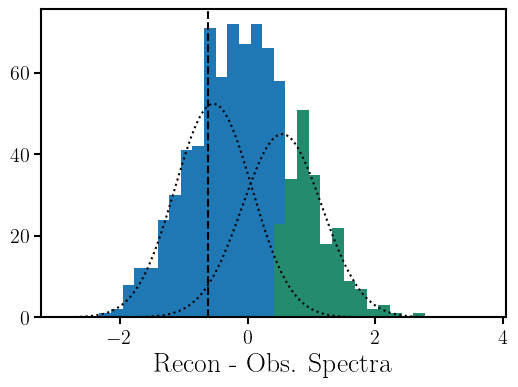

gal 11, z=3.09 norm=1.09
skew 0.482, sigma=0.40, dAlya=1.51
[-0.33325204  0.64358953]
[0.47593648 0.6130835 ]
[0.69893411 0.30106589]


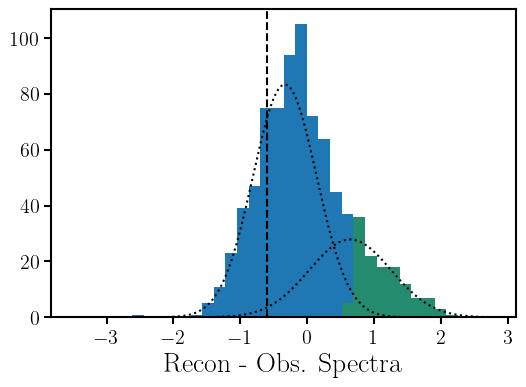

gal 12, z=3.26 norm=0.29
skew -0.125, sigma=1.95, dAlya=0.22
[-1.0402242   1.14257879]
[1.63824233 1.52570821]
[0.51283324 0.48716676]


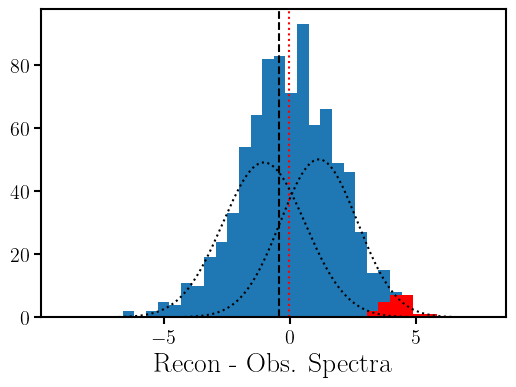

gal 13, z=2.99 norm=0.73
skew 0.039, sigma=0.91, dAlya=0.37
[-0.6310193   0.43358244]
[0.83396362 0.84274318]
[0.52334236 0.47665764]


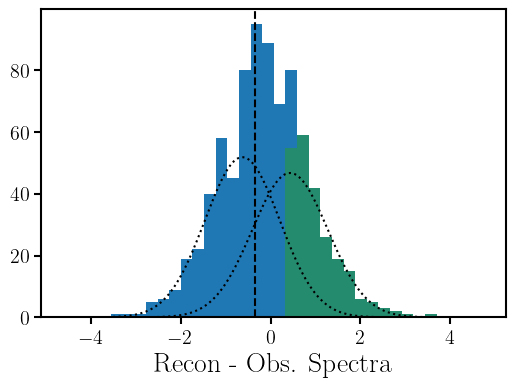

gal 14, z=3.45 norm=1.07
skew 0.337, sigma=0.46, dAlya=0.81
[-0.31703794  0.44284891]
[0.45247178 0.55272176]
[0.55222506 0.44777494]


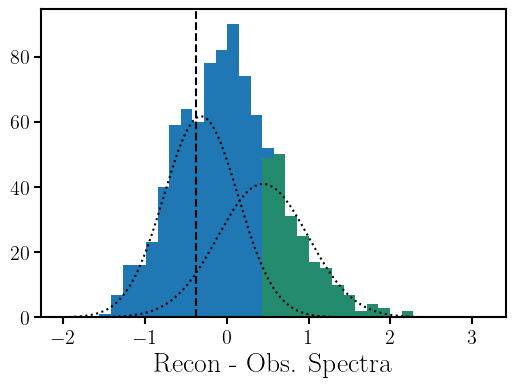

gal 15, z=3.41 norm=1.41
skew 0.353, sigma=0.24, dAlya=1.81
[ 0.21176821 -0.27333805]
[0.37803918 0.3056889 ]
[0.41323771 0.58676229]


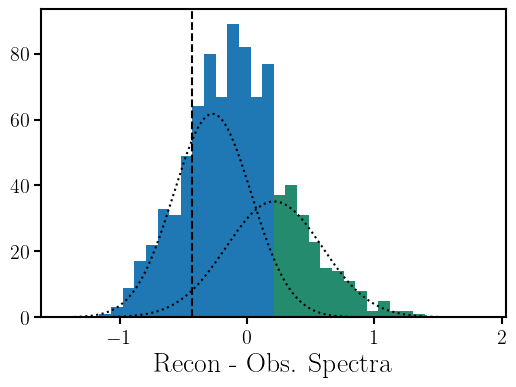

gal 16, z=3.39 norm=0.77
skew 0.198, sigma=0.66, dAlya=1.02
[ 0.40472101 -0.57252889]
[0.69010293 0.62819314]
[0.49889583 0.50110417]


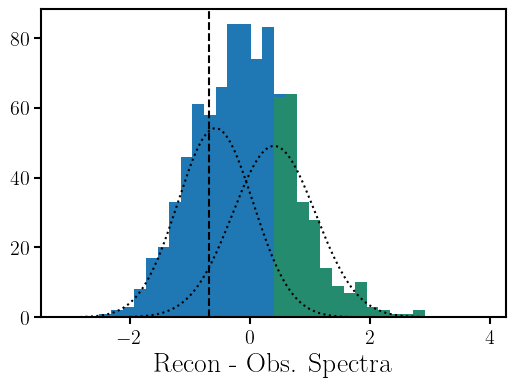

gal 17, z=3.31 norm=0.40
skew -0.140, sigma=1.36, dAlya=0.19
[ 0.8386629  -0.82455187]
[1.12230473 1.21680513]
[0.56800397 0.43199603]


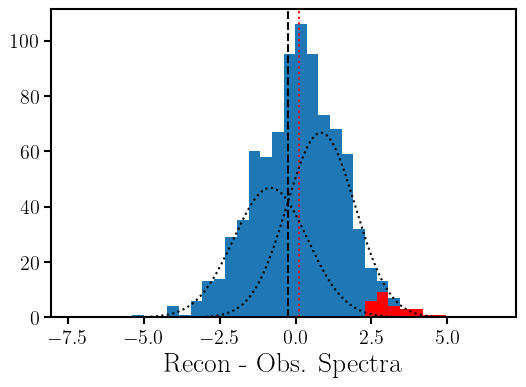

gal 18, z=3.26 norm=0.38
skew 0.013, sigma=1.46, dAlya=0.27
[-0.85080548  0.8007398 ]
[1.22179919 1.22730232]
[0.49850939 0.50149061]


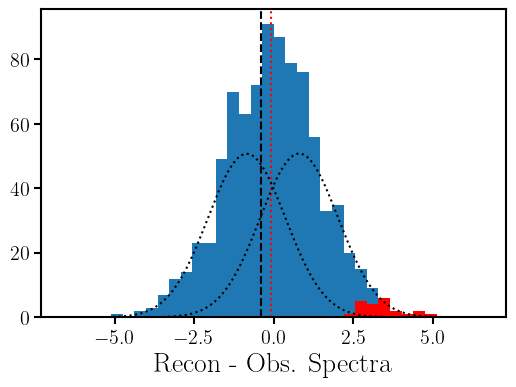

gal 19, z=3.42 norm=0.24
skew 0.053, sigma=1.97, dAlya=0.20
[-1.27162002  1.37503684]
[1.70560215 1.74914981]
[0.49635765 0.50364235]


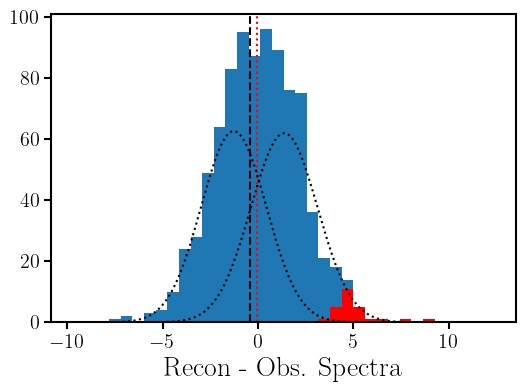

gal 20, z=3.48 norm=0.19
skew -0.201, sigma=2.44, dAlya=0.21
[-1.81012787  1.28897767]
[2.22382135 2.00577565]
[0.4555283 0.5444717]


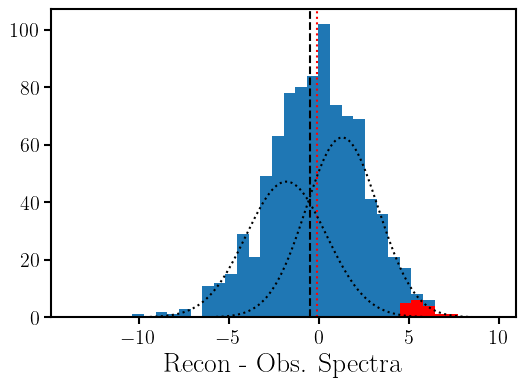

gal 21, z=2.13 norm=0.27
skew -0.030, sigma=6.93, dAlya=0.04
[-4.19309341  2.65696743]
[6.64168015 6.35776382]
[0.34922004 0.65077996]


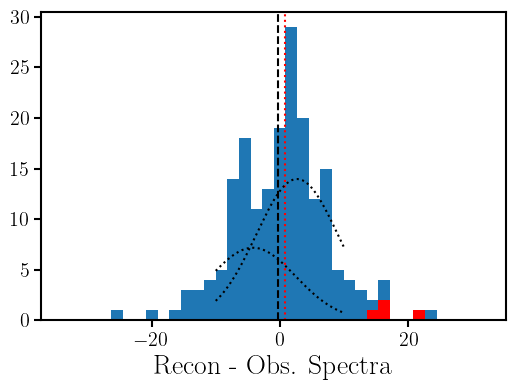

gal 22, z=2.26 norm=0.30
skew -0.043, sigma=4.75, dAlya=0.10
[-0.11813707  0.20899499]
[3.81661227 9.1120305 ]
[0.68985781 0.31014219]


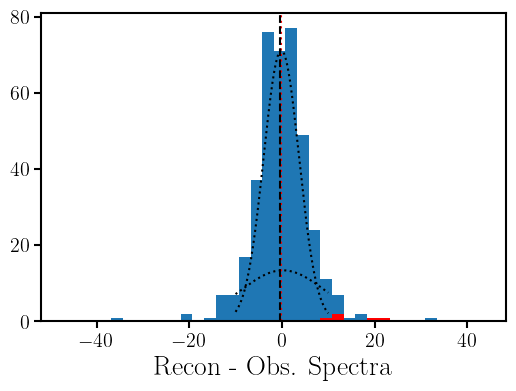

gal 23, z=2.35 norm=0.42
skew 0.498, sigma=2.99, dAlya=0.14
[ 0.32099476 -0.22623852]
[5.16305697 2.39465159]
[0.38523508 0.61476492]


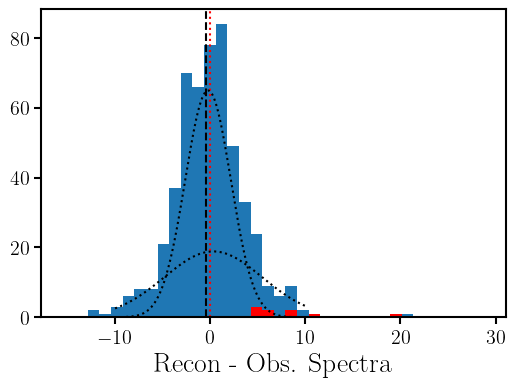

gal 24, z=2.24 norm=0.23
skew -0.470, sigma=6.49, dAlya=0.06
[-0.00765122 -0.4359464 ]
[11.21981651  5.41986991]
[0.44906703 0.55093297]


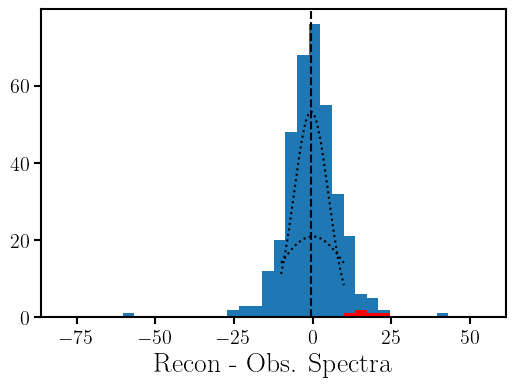

gal 25, z=2.28 norm=1.35
skew -0.015, sigma=1.07, dAlya=0.21
[-0.67473921  0.51822437]
[1.16045544 1.23107266]
[0.54259925 0.45740075]


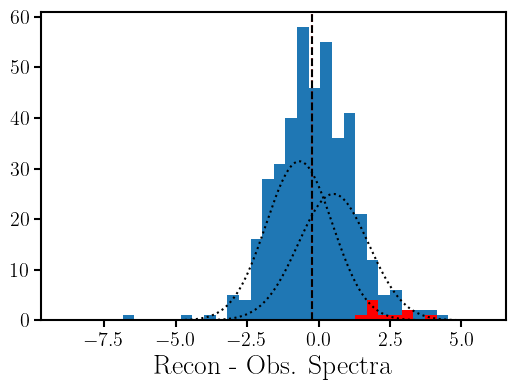

gal 26, z=2.30 norm=1.13
skew 1.195, sigma=1.21, dAlya=0.13
[ 0.20921929 -0.20029966]
[2.62954408 1.04267561]
[0.25163681 0.74836319]


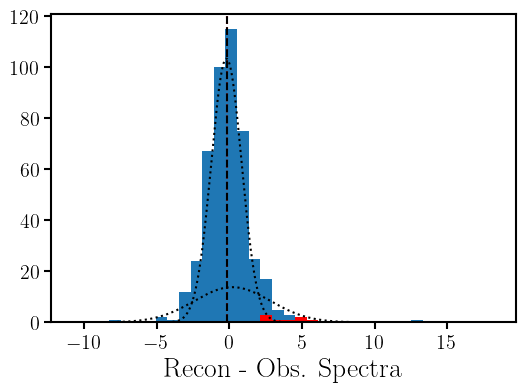

gal 27, z=2.33 norm=0.39
skew 0.120, sigma=3.25, dAlya=0.00
[-0.20417186  0.15608799]
[2.80415081 5.79195353]
[0.61543066 0.38456934]


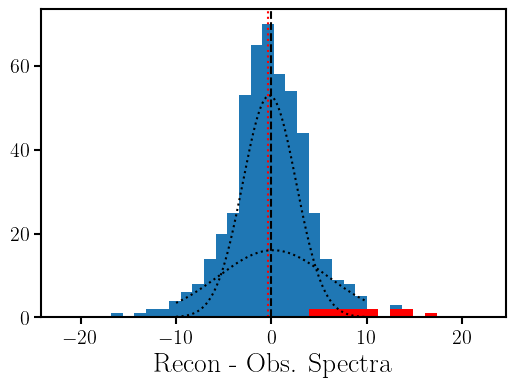

gal 28, z=2.31 norm=0.91
skew 0.238, sigma=1.46, dAlya=0.26
[0.2090822  0.03180155]
[2.3657284  1.08543854]
[0.41229046 0.58770954]


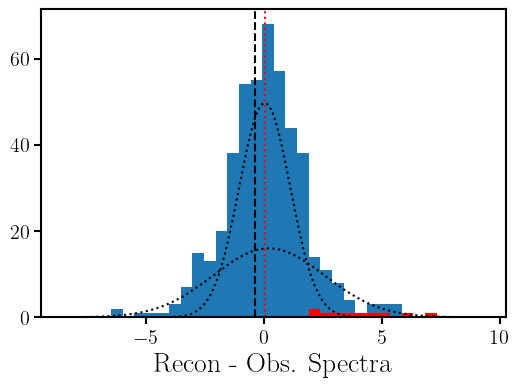

gal 29, z=2.25 norm=0.23
skew 0.093, sigma=6.18, dAlya=0.05
[ 1.93621785 -3.82782691]
[6.4677215  6.44544208]
[0.58670231 0.41329769]


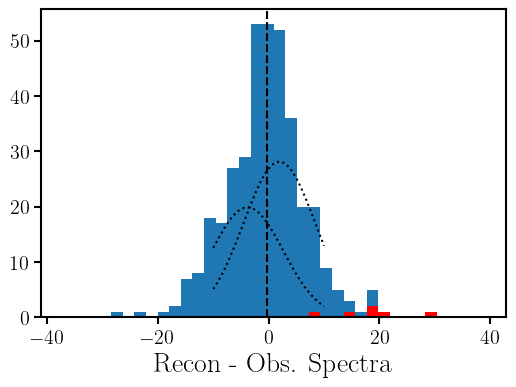

In [59]:
for ii, igal in enumerate(np.arange(len(z))[:30]):
    inforest = (models[0].wave_obs/(1+z[igal]) > 1040) & (models[0].wave_obs/(1+z[igal]) < 1200)
    drecon = np.array(recon_rebin[igal] - np.array(spec[igal]))[inforest]
    
    print('gal %i, z=%.2f norm=%.2f' % (igal, float(z[igal]), float(norm[igal])))
    print('skew %.3f, sigma=%.2f, dAlya=%.2f' % (skewy[igal], noise_forest[igal], dAlya[igal]))
    
    # fit a Gaussian mixture model 
    gmm = GMix(n_components=2)
    gmm.fit(drecon.reshape(-1, 1))    
    gmm_means = gmm.means_.flatten()
    gmm_sigmas = gmm.covariances_.flatten()**0.5
    gmm_weights = gmm.weights_
    print(gmm_means)
    print(gmm_sigmas)
    print(gmm_weights)
    
    # select continuum Gaussian
    couldbe_cont = (gmm_means < 0.) & (gmm_weights > 0.1)
    if np.sum(couldbe_cont) > 0: 
        g_cont = np.arange(2)[couldbe_cont][np.argmin(gmm_means[couldbe_cont])]
    else: 
        g_cont = None
    
    fig = plt.figure(figsize=(6,4))
    sub = fig.add_subplot(111)
    h = sub.hist(drecon, range=(drecon.min()*1.5, drecon.max()*1.5), bins=40)
    
    if noise_forest[igal] < 1: 
        if g_cont is not None:
            gmm_sig = drecon > gmm_means[~g_cont] #+ gmm_sigmas[g_cont]
            _ = sub.hist(drecon[gmm_sig], range=(drecon.min()*1.5, drecon.max()*1.5), bins=40, color='C2', alpha=0.5)
    else: 
        sig3 = drecon > 2. * np.array(w[igal])[inforest]**-0.5
        _ = sub.hist(drecon[sig3], range=(drecon.min()*1.5, drecon.max()*1.5), bins=40, color='r')
        sub.axvline(np.median(drecon[~sig3]), color='r', linestyle=':')
        
    # plot best-fit GMM
    _x = np.linspace(-10, 10, 10000)
    for _i in range(i_best+2):
        _gauss = sp_norm.pdf(_x, gmm_means[_i], gmm_sigmas[_i])
        sub.plot(_x, np.sum(h[0] * np.diff(h[1])) * gmm_weights[_i] * _gauss, c='k', ls=':')
    #_ = sub.hist((true_rebin[igal] - spec[igal])[inforest], alpha=0.5, range=(-5., 5), bins=40)
    sub.axvline((np.array(A_lya_spender) - np.array(A_lya_true))[igal], color='k', linestyle='--')    
    sub.set_xlabel('Recon - Obs. Spectra', fontsize=20)
    sub.set_xlim(drecon.min()*1.5, drecon.max()*1.5)
    plt.show()